In [ ]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import opendatasets as od

od.download('https://www.kaggle.com/datasets/ingbiodanielh/vizwiz')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mohabali01
Your Kaggle Key: ··········


100%|██████████| 28.7G/28.7G [24:21<00:00, 21.1MB/s]


OSError: ignored

In [ ]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 5.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-8nmtlise
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-8nmtlise
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369370 sha256=fc38c53ca893471f99219b0da7f66df24b82653a2fedadb9aba6cda0305f7055
  Stored in directory: /tmp/pip-ephem-wheel-cache-l8rj8u7d/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [ ]:
import os
import clip
import numpy as np
import torch
from PIL import Image
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
img = Image.open('/content/vizwiz/data/Images/VizWiz_train_000000000000.jpg')

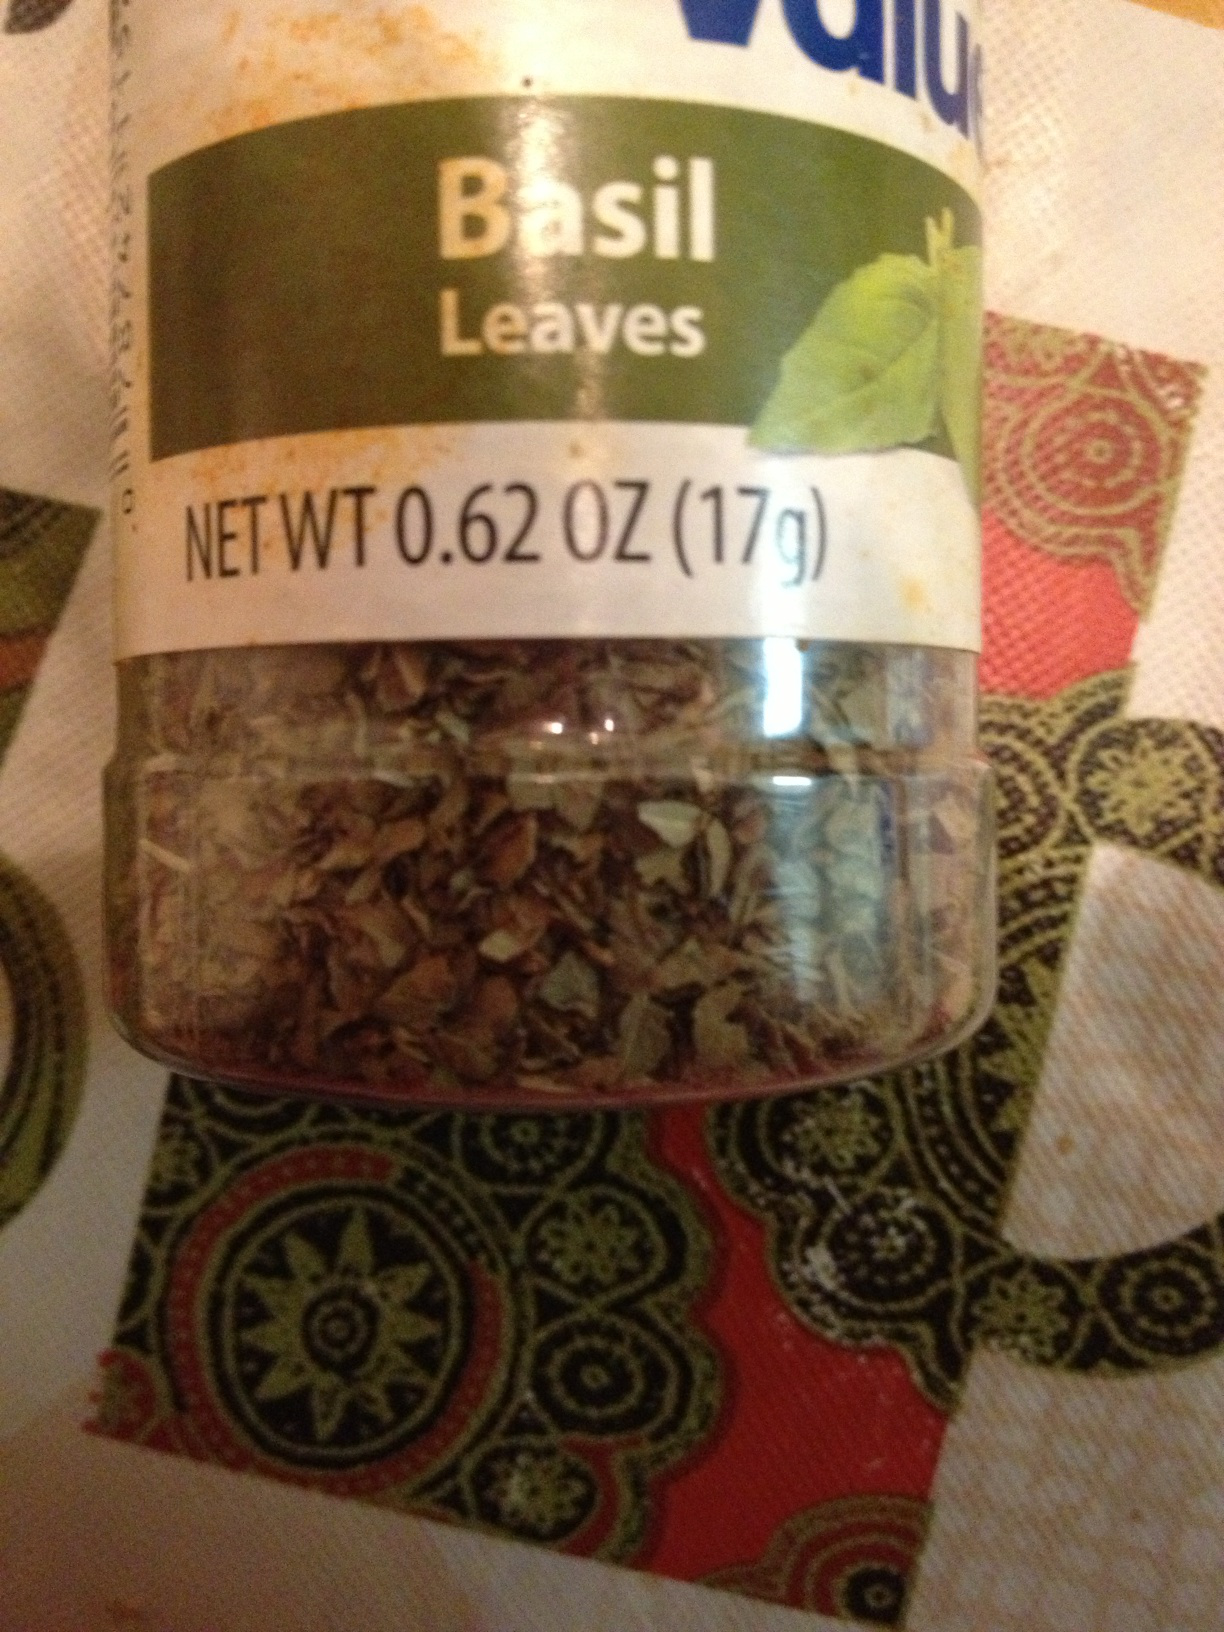

In [ ]:
img.show()

In [ ]:
df = pd.read_json('/content/vizwiz/data/Annotations/train.json')

In [ ]:
df.head(1)

,answerable,image,question,answer_type,answers
0,1,VizWiz_train_000000000000.jpg,What's the name of this product?,other,"[{'answer_confidence': 'yes', 'answer': 'basil..."


In [ ]:
model, preprocess = clip.load('ViT-B/32', device=device)

100%|███████████████████████████████████████| 338M/338M [00:10<00:00, 34.4MiB/s]


In [ ]:
img_processed = preprocess(img).to(device)

In [ ]:
text = df.head(1)['answers']

In [ ]:
text

0    [{'answer_confidence': 'yes', 'answer': 'basil...
Name: answers, dtype: object

In [ ]:
text.to_numpy()[0][0]['answer']

'basil leaves'

In [ ]:
answers = []
answer_types = []
imgs = []
questions = []

for idx,entry in df.head(1000).iterrows():
  answers.append(entry['answers'][0]['answer'])
  answer_types.append(entry['answers'][0]['answer_confidence'])
  questions.append(entry['question'])
  imgs.append(entry['image'])

In [ ]:
questions[:5]

["What's the name of this product?",
 'Can you tell me what is in this can please?',
 'Is this enchilada sauce or is this tomatoes?  Thank you.',
 'What is the captcha on this screenshot?',
 'What is this item?']

In [ ]:
answers[:5]

['basil leaves',
 'soda',
 'these tomatoes not enchilada sauce',
 't36m',
 'solar garden light']

In [ ]:
answer_types[:5]

['yes', 'yes', 'yes', 'yes', 'yes']

In [ ]:
imgs[:5]

['VizWiz_train_000000000000.jpg',
 'VizWiz_train_000000000001.jpg',
 'VizWiz_train_000000000002.jpg',
 'VizWiz_train_000000000003.jpg',
 'VizWiz_train_000000000004.jpg']

In [ ]:
imgs_actual = []

for img in imgs:
  imgs_actual.append(preprocess(Image.open('/content/vizwiz/data/Images/'+img)).unsqueeze(0).to(device))

In [ ]:
imgs_actual[0].size()

torch.Size([1, 3, 224, 224])

In [ ]:
data = []

with torch.no_grad():
  for img,q in zip(imgs_actual, questions):
    enc_img = model.encode_image(img)
    enc_q = model.encode_text(clip.tokenize(q).to(device))

    data.append(torch.cat((enc_img, enc_q),dim=1).squeeze())

In [ ]:
data = torch.stack(data)

In [ ]:
data.size()

torch.Size([1000, 1024])

In [ ]:
labels = []

with torch.no_grad():
  for answer,a_type in zip(answers, answer_types):
    enc_answer = model.encode_text(clip.tokenize(answer).to(device))
    enc_type = model.encode_text(clip.tokenize(a_type).to(device))

    # labels.append(torch.stack([enc_answer, enc_type]))
    labels.append(enc_answer)

In [ ]:
labels = torch.stack(labels).squeeze()

In [ ]:
labels.size()

torch.Size([1000, 512])

In [ ]:
labels = labels.to('cpu')
data = data.to('cpu')

In [ ]:
labels = labels.reshape((1000,1024))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.05, random_state=42)

In [ ]:
from torch.utils.data import Dataset, DataLoader

# Custom Dataset class
class VQADataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        label = self.labels[index]

        return x, label

In [ ]:
train_set = DataLoader(VQADataset(X_train, y_train), batch_size=32)
test_set = DataLoader(VQADataset(X_test, y_test), batch_size=32)

In [ ]:
class VQA_Network(nn.Module):
    def __init__(self, num_classes, vocab_size, hidden_dim, num_layers):
        super(VQA_Network, self).__init__()

        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim

        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers)
        self.fc2_answers = nn.Linear(hidden_dim, vocab_size)

        self.norm = nn.LayerNorm(hidden_dim)
        self.dropout = nn.Dropout()
        self.softmax = nn.SoftMax()


    def forward(self, x,seq_len):

        # Pass through the first fully connected layer
        x = x.to(dtype=torch.float32)
        ouptut_seq = []
        for _ in range(seq_len):
          output, hidden = self.lstm(x, hidden)
          output = self.norm(output)
          output = self.dropout(output)
          output = self.fc2_answers(output)
          output = self.softmax(output)



        return answers, hidden


In [ ]:
# Instantiate the model
model = VQA_Network(8).to(device)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training loop
for epoch in range(200):
    model.train()
    running_loss = 0.0

    for xs, labelset in train_set:
        # Move data to the device
        xs = xs.to(device)
        labelset = labelset.to(device)

        # Clear gradients
        optimizer.zero_grad()

        # Forward pass
        answers = model(xs)
        print(xs.size())
        print(labelset.size())
        # Compute loss
        loss = criterion(answers, labelset)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Update running loss
        running_loss += loss.item()

    # Calculate average loss for the epoch
    average_loss = running_loss / len(data_loader)

    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")

# Training complete


torch.Size([32, 1024])
torch.Size([32, 512])


RuntimeError: ignored